In [1]:
import os
os.chdir("../")
print("Moved up")

Moved up


In [2]:
import importlib
import copy
import pickle
import typing as tp
from functools import partial

import jax
import jax.numpy as jnp
import jax.flatten_util as fu
from flax import linen as nn  # Linen API
import numpy as np
import matplotlib.pyplot as plt
import optax
import math

from tqdm import tqdm
import time

import lib_data
import utils
import modules
import callbacks

%env XLA_PYTHON_CLIENT_MEM_FRACTION=.9
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("devices", jax.devices())

shade_colours = plt.get_cmap('Set3')
dark_colours = plt.get_cmap('tab10')
all_colours = plt.get_cmap('tab20')

def light_colours(i):
    return all_colours(2*i+1)

2025-03-29 10:56:41.565842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743245801.579811 3489802 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743245801.584072 3489802 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.9
devices [CudaDevice(id=0)]


In [ ]:
# %env XLA_FLAGS=--xla_gpu_deterministic_ops=true
# %env XLA_FLAGS=--xla_gpu_deterministic_reductions=true
%env XLA_FLAGS=--xla_gpu_deterministic_ops=true --xla_gpu_deterministic_reductions=true

# Dataset

Clean 1000 Corrupt 0
class labels: [0 5 2 9 6 4 0 9 2 7]


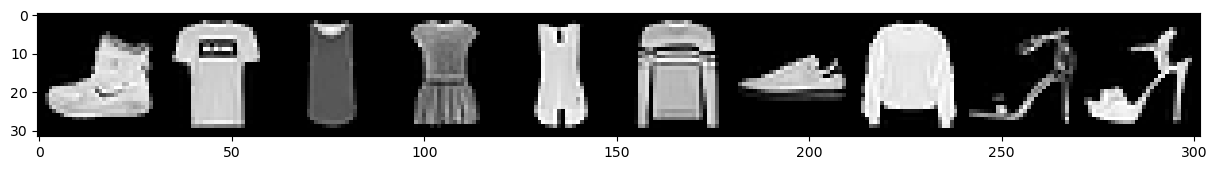

3


In [13]:
#-----------------------------------------------------------------------------------------------------------------------------
n_out = 10

n_train: int = 100 * n_out
n_eval: int = 20 * n_out
n_hess: int = 100 * n_out
use_mse = False

utils.set_seed(0)
importlib.reload(lib_data)
def __get_datasets():
    datasets = lib_data.get_fashion_mnist(flatten=False, tr_indices=n_train, te_indices=n_eval, hess_indices=n_hess,
                            tr_classes=n_out, te_classes=n_out, hess_classes=n_out, one_hot = use_mse, 
                              visualise=True)

    data_name = "fmnist_"+str(n_out)+"cl_"+str(n_train) + "_" + str(n_eval) 
    print(len(datasets))
    return datasets, data_name

datasets, data_name = __get_datasets()

# Architecture

In [14]:
importlib.reload(modules)

def __get_arch__():
    depth = 3
    n_h = 32
    use_DO = False
    use_BN = False
    
    model = modules.MLPNet(depth, n_h, n_out, use_BN=use_BN, use_DO=use_DO, inputs_flatten=True)
    model_name = f"MLP{depth}_nh{n_h:d}"
    
    if use_DO:
        model_name += "_DO"
    if use_BN:
        model_name += "_BN"
    return model, model_name
    
model_arch, model_name = __get_arch__()
print(model_name)

MLP3_nh32


# Optimizer

In [15]:
#-----------------------------------------------------------------------------------------------------------------------------
importlib.reload(modules)
from optax import contrib

def __get_optim__(warmup_steps, lr, b1, b2, b3, option="", rho=None, sync_period=1):
    # warmup_steps, lr, b1, b2, b3 = hyps['warmup_steps'], hyps['lr'], hyps['b1'], hyps['b2'], hyps['b3']
    if option == 'sam':
        assert rho is not None
        warmup_scheduler = optax.linear_schedule(init_value=0.0, end_value=lr,
                                                transition_steps=warmup_steps,
                                                transition_begin=0,)
        constant_scheduler = optax.constant_schedule(lr)
        lr_scheduler = optax.join_schedules([warmup_scheduler, constant_scheduler], boundaries=[warmup_steps])
        base_opt = modules.get_sgd_optimizer(lr_scheduler, b1, b2, b3, verbose=False)
        adv_opt = modules.get_sgd_optimizer(rho, b1, b2, b3, verbose=False)
        optimizer = contrib.sam(base_opt, adv_opt, sync_period=sync_period, opaque_mode=True) # sam opt
        optim_name = f"sgdFam-SAM_1b{b1}_2b{b2}_3b{b3}_lr{lr}_warmup{warmup_steps}_rho{rho}_syncT{sync_period}"

    else:
        warmup_scheduler = optax.linear_schedule(init_value=0.0, end_value=lr,
                                                transition_steps=warmup_steps,
                                                transition_begin=0,)
        constant_scheduler = optax.constant_schedule(lr)
        lr_scheduler = optax.join_schedules([warmup_scheduler, constant_scheduler], boundaries=[warmup_steps])
        optimizer = modules.get_sgd_optimizer(lr_scheduler, b1, b2, b3, verbose=False)
        optim_name = f"sgdFam_1b{b1}_2b{b2}_3b{b3}_lr{lr}_warmup{warmup_steps}"
        
    return optimizer, optim_name

optimizer, optim_name = __get_optim__(2, 0.1, 0, 0, 0)

# Model Params (Fixed and Tuned)

In [19]:
#-----------------------------------------------------------------------------------------------------------------------------
import itertools
### FIXED
warmup_steps = 0
bs = 1000
eval_bs = 2000
n_epochs = 400
loss_fn = optax.softmax_cross_entropy_with_integer_labels
# loss_fn = optax.squared_error

# FLEXIBLE
# lr = 0.005
# beta_list = [(0., 0., 0.), (0., 0.99, 0.)]
# optim_hp = LR, B1, B2, B3, SAM, Rho, sync_period
optim_hp_list = [
    (0.1, 0., 0., 0., False, 0., 1), 
    # (0.1, 0., 0., 0., True, 0.1, 1), 
    # (5e-3, 0., 0.9, 0., False, 0., 1), 
    # (5e-3, 0., 0.9, 0., True, 0., 1), 
    # (5e-3, 0., 0.9, 0., True, 0.1, 1), 
    # (5e-3, 0.9, 0.99, -1.0, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -1.0, True, 0.01, 1), 
    # (5e-3, 0.9, 0.99, -0.5, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -0.1, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -0.05, False, 0., 1),
    # (5e-3, 0.9, 0.99, -0.01, False, 0., 1),
    # (5e-3, 0.9, 0.99, -0.005, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -0.001, False, 0., 1), 
]
seed_list = [x for x in range(1)]
# seed_list = [1352] # just to check new SAM with new loss_wrap
# sam_list = [False, True]
s = [optim_hp_list, seed_list]
hyp_list = list(itertools.product(*s))
print(len(hyp_list))

1


# Callbacks

In [17]:
#-----------------------------------------------------------------------------------------------------------------------------
sws = 1
cb_freq = 1
# hess_freq = int(1e8) # really large
hess_freq = 1
importlib.reload(callbacks)
def __get_cbs__(state, option, compute_hessian=False):
    bn = False if option == "" else True
    cbs = []
    cbs.append(callbacks.saveWeightsCB(sws, grad=True))
    # cbs.append(callbacks.thinCB(thin_freq=cb_freq))

    if compute_hessian:
        hvpCB = callbacks.hvpCB(loss_fn=loss_fn, batches=(datasets[2].data[:n_hess], datasets[2].targets[:n_hess]), 
                            save_freq=hess_freq, hess_bs=n_hess, state=state, bn=bn)
        cbs.append(hvpCB)   
        specCB = callbacks.spectrumCB(n_eigs=20, n_evecs=10, 
                    loss_fn=loss_fn, seed=seed, hvpCB=hvpCB, save_freq=hess_freq, verbose=False)
        cbs.append(specCB)

    # esCB = callbacks.earlyStopCB(acc_threshold=0.999, cbs=None, min_eps=sws, max_eps=n_epochs, conseq_eps=2,
    #                              final_cbs=[hvpCB, specCB], verbose=False, low_eps=max(sws, 100), low_thresh=0.11, )
    # cbs.append(esCB)
    return cbs


# Train State

In [18]:
from flax import struct                # Flax dataclasses
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
importlib.reload(modules)

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics
    batch_stats: tp.Any

class TrainStateSAM(modules.TrainStateSAM):
    metrics: Metrics
    batch_stats: tp.Any

def create_train_state(model, optimizer, inputs, rng, option=""):
    """Creates an initial `TrainState`."""
    if option == "":
        params = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :]))['params'] # initialize parameters by passing a template image
        
        tx = optimizer
        return TrainState.create(
          apply_fn=model.apply, params=params, tx=tx, metrics=Metrics.empty())
        
    elif option == "bn":
        variables = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :])) # initialize parameters by passing a template image
        params = variables['params']
        batch_stats = variables['batch_stats']
        
        tx = optimizer
        return TrainState.create(
          apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats, 
          metrics=Metrics.empty())
        
    elif option == "sam":
        variables = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :])) # initialize parameters by passing a template image
        params = variables['params']
        batch_stats = variables['batch_stats']
        
        tx = optimizer
        return TrainStateSAM.create(
          apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats, 
          metrics=Metrics.empty())
    else:
        raise NotImplementedError
        
        

# Training

In [28]:
#-----------------------------------------------------------------------------------------------------------------------------
import training
importlib.reload(training)

load_files = False
compute_hessian = True
force_train = False

all_mh = []
all_exp_names = []

for hyp in hyp_list:
    
    metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

    lr, b1, b2, b3, sam, sam_rho, sync_T = hyp[0]
    seed = hyp[1]
    option = 'sam' if sam else "bn"
    
    if datasets is None:
        datasets, data_name = __get_datasets__()
    
    train_loader = lib_data.NumpyLoader(datasets[0], batch_size=bs, shuffle=True)
    for sample_batch in train_loader:
        break
    
    test_loader = lib_data.NumpyLoader(datasets[1], batch_size=eval_bs)
    dataloaders = [train_loader, test_loader]
    
    model, model_name = __get_arch__()
    model_name += "_seed"+str(seed)

    optim, optim_name = __get_optim__(warmup_steps, lr, b1, b2, b3, option=option, rho=sam_rho, sync_period=sync_T)
    optim_name += f"_epochs{n_epochs}_bs{bs}"

    init_rng = jax.random.PRNGKey(seed)
    state = create_train_state(model, optim, sample_batch[0], init_rng, option=option)
    del init_rng  # Must not be used anymore.
    
    cbs = __get_cbs__(state, compute_hessian=compute_hessian)
    cb_name_str = utils.get_callback_name_str(cbs)
    cb_name_list = utils.get_callback_name_list(cbs)
    # break
    num_params = utils.count_params(state.params)
    print("num params", num_params)

    experiment_name = utils.get_now() + "_" + data_name + "_" + model_name + "_" + optim_name
    
    try:
        if force_train:
            raise FileNotFoundError
        experiment_name, lse = utils.find_latest_exp(experiment_name, n_epochs, save_freq=cb_freq, 
                                                   cbs=cb_name_list, unknown_lse=True, verbose=False)
        metrics_history = utils.load_thing("traj/" + experiment_name + "/metrics.pkl")
        print(f"tr_acc: {metrics_history['train_accuracy'][-1]:0%}, te_acc: {metrics_history['test_accuracy'][-1]:0%}")
        metrics_history['lse'] = [lse]
        if compute_hessian:
            eigvals = utils.load_thing("traj/" + experiment_name + "/eigvals.pkl")
            metrics_history['eigvals'] = eigvals
            print(f"sharp: {metrics_history['eigvals'][-1][0]}")

    except FileNotFoundError:
        metrics_history = training.train_model(state, model, loss_fn, metrics_history, n_epochs, dataloaders, \
                                                   experiment_name, cbs, option=option, force_fb=True, tqdm_over_epochs=10)         
        
    all_mh.append(metrics_history)
    all_exp_names.append(experiment_name)
    
    print(experiment_name, "complete")
    print("\n ---------------------------------------------------------------------------------------------------------\n")
# Training: datasets, hps, arch_func, optim_func, cb_func, -> train model


num params 32782
tr_acc: 99.902344%, te_acc: 46.150002%
sharp: 3147965.25
250211-1104_cifar10_10cl_5120_2000_VGG10_base8_BN_seed0_sgdFam_1b0.0_2b0.0_3b0.0_lr0.1_warmup2_epochs2000_bs64 complete

 ---------------------------------------------------------------------------------------------------------

num params 32782
tr_acc: 99.902344%, te_acc: 47.350001%
sharp: 740278.0625
250211-1108_cifar10_10cl_5120_2000_VGG10_base8_BN_seed0_sgdFam-SAM_1b0.0_2b0.0_3b0.0_lr0.1_warmup2_rho0.1_syncT1_epochs2000_bs64 complete

 ---------------------------------------------------------------------------------------------------------

num params 32782
tr_acc: 99.902344%, te_acc: 50.550002%
sharp: 48538541096960.0
250211-1113_cifar10_10cl_5120_2000_VGG10_base8_BN_seed0_sgdFam_1b0.0_2b0.9_3b0.0_lr0.005_warmup2_epochs2000_bs64 complete

 ---------------------------------------------------------------------------------------------------------

num params 32782
tr_acc: 99.902344%, te_acc: 50.550002%
sharp: 5

In [20]:
print(len(optim_hp_list), len(all_mh))

13 13


# Results

In [29]:
optim_names = ['SGD', 'SGD-SAM', 'ADAM', 'ADAM-SAM-R0', 'ADAM-SAM', 'ADAM-UB-1e0', 'ADAM-UB-1e0-SAM', 'ADAM-UB-5e-1','ADAM-UB-1e-1', 'ADAM-UB-5e-2', 'ADAM-UB-1e-2', 'ADAM-UB-5e-3','ADAM-UB-1e-3']
stat_names = ['train_accuracy', 'test_accuracy', 'lse']
n_seeds = len(seed_list)
for i in range(len(optim_hp_list)):
    stats = [ 0 for j in range(len(stat_names))]
    for j in range(len(stats)):
        for k in range(n_seeds*i, n_seeds*i+n_seeds):
            stats[j] += all_mh[k][stat_names[j]][-1]
    out = f"{optim_names[i]}"
    for j in range(len(stats)):
        out += f", {stat_names[j]}:{stats[j]/n_seeds}"
    print(out)
    # print(optim_hp_list[i], np.mean(all_mh[3*i:3*i+3]['train_accuracy'][-1]), np.mean(all_mh[3*i:3*i+3]['test_accuracy'][-1]))

SGD, train_accuracy:0.9990234375, test_accuracy:0.46150001883506775, lse:145.0
SGD-SAM, train_accuracy:0.9990234375, test_accuracy:0.47350001335144043, lse:227.0
ADAM, train_accuracy:0.9990234375, test_accuracy:0.5055000185966492, lse:783.0
ADAM-SAM-R0, train_accuracy:0.9990234375, test_accuracy:0.5055000185966492, lse:605.0
ADAM-SAM, train_accuracy:0.9990234375, test_accuracy:0.4740000367164612, lse:574.0
ADAM-UB-1e0, train_accuracy:0.9996094107627869, test_accuracy:0.5175000429153442, lse:538.0
ADAM-UB-1e0-SAM, train_accuracy:0.9990234375, test_accuracy:0.49000000953674316, lse:453.0
ADAM-UB-5e-1, train_accuracy:0.999218761920929, test_accuracy:0.503000020980835, lse:529.0
ADAM-UB-1e-1, train_accuracy:0.999218761920929, test_accuracy:0.49400001764297485, lse:505.0
ADAM-UB-5e-2, train_accuracy:0.9990234375, test_accuracy:0.4985000193119049, lse:478.0
ADAM-UB-1e-2, train_accuracy:0.9990234375, test_accuracy:0.4805000126361847, lse:408.0
ADAM-UB-5e-3, train_accuracy:0.999218761920929, t

# Analysis